In [2]:
library(qdapRegex) 
library(stringr)    
library(tidyverse)  
library(SnowballC)    
library(wordcloud)  
library(tidytext)
library(RColorBrewer)
library(tm)
library(quanteda)
library(data.table)
library(ggplot2)
library(dplyr)
library(Matrix)
library(stringr)

In [3]:
pca_scores <- fread("episode_pca_scores_filtered.csv")

Warning message:
"Unknown or uninitialised column: `merged_category`."


< table of extent 0 >

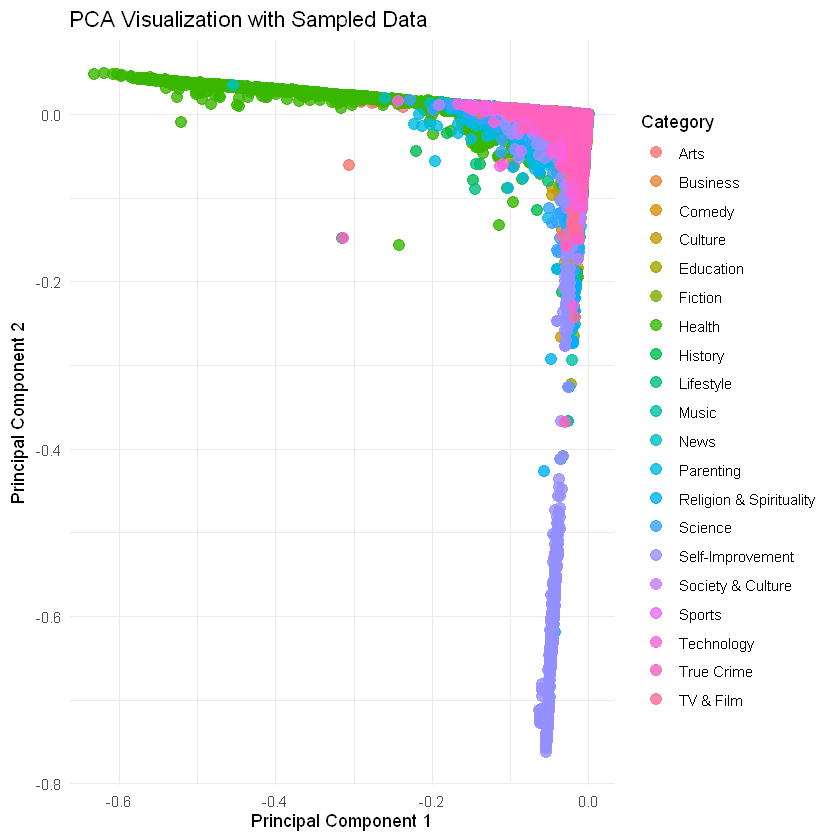

In [17]:
# 每个类别最多保留 5000 条记录
set.seed(123)  # 设置随机种子，确保结果可重复
sampled_pca_scores <- pca_scores %>%
  group_by(category) %>%  # 按合并后的类别分组
  slice_sample(n = 5000) %>%  # 每组最多保留 5000 条记录
  ungroup()  # 取消分组，方便后续操作

# 查看每个类别保留的样本数量
table(sampled_pca_scores$merged_category)

# 绘制抽样后的 PCA 可视化图
ggplot(sampled_pca_scores, aes(x = PC1, y = PC2, color = category)) +
  geom_point(size = 3, alpha = 0.8) +
  labs(
    title = "PCA Visualization with Sampled Data",
    x = "Principal Component 1",
    y = "Principal Component 2",
    color = "Category"
  ) +
  theme_minimal() +
  theme(legend.position = "right")

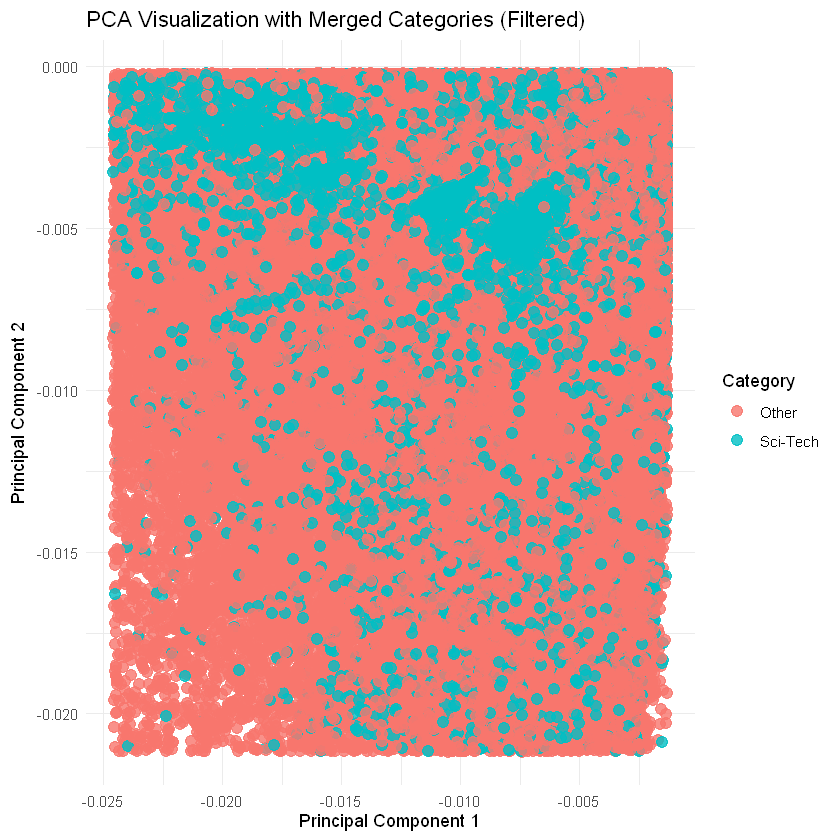

In [8]:
# 合并类别
pca_scores <- pca_scores %>%
  mutate(
    merged_category = case_when(
      category %in% c("Arts") ~ "Sci-Tech",  # 合并为"科技"
      TRUE ~ "Other"  # 其他类别归为"Other"
    )
  )

# 计算 PC1 和 PC2 的上下分位数范围（例如：10% 和 90%）
pc1_limits <- quantile(pca_scores$PC1, probs = c(0.1, 0.9))
pc2_limits <- quantile(pca_scores$PC2, probs = c(0.1, 0.9))

# 筛选出位于范围内的数据点（减少数据量以提高绘图效率）
filtered_pca_scores <- pca_scores %>%
  filter(
    PC1 >= pc1_limits[1], PC1 <= pc1_limits[2],
    PC2 >= pc2_limits[1], PC2 <= pc2_limits[2]
  )

# 绘制过滤后的 PCA 可视化图
ggplot(filtered_pca_scores, aes(x = PC1, y = PC2, color = merged_category)) +
  geom_point(size = 3, alpha = 0.8) +  # 绘制散点图
  labs(
    title = "PCA Visualization with Merged Categories (Filtered)",
    x = "Principal Component 1",
    y = "Principal Component 2",
    color = "Category"
  ) +
  theme_minimal() +
  theme(legend.position = "right")  # 图例放在右侧

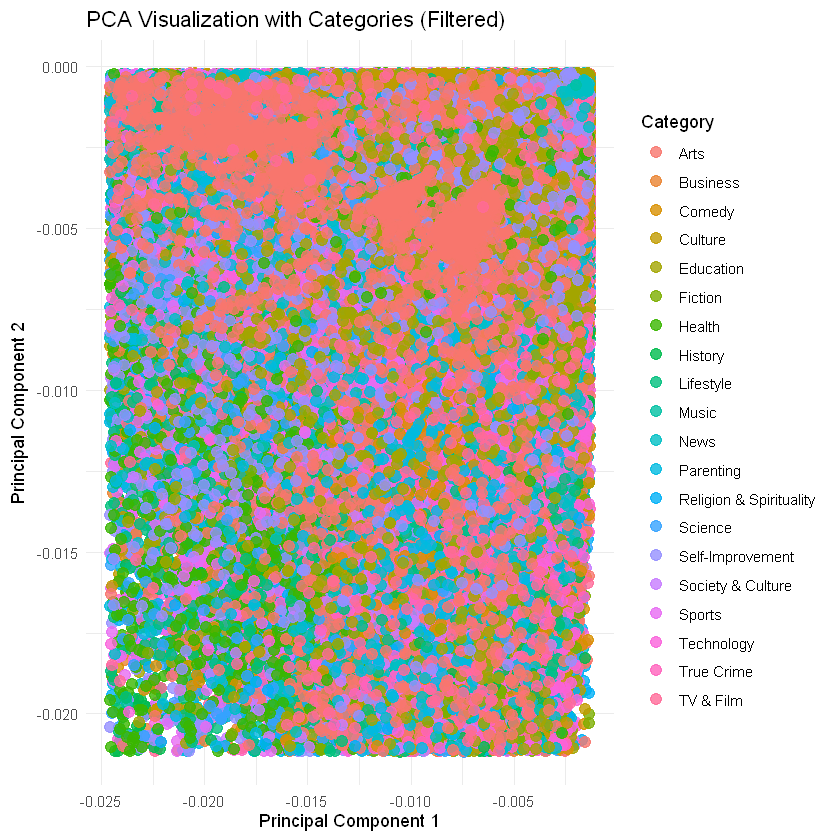

In [6]:
# 计算 PC1 和 PC2 的上下分位数范围（例如：1% 和 99%）
pc1_limits <- quantile(pca_scores$PC1, probs = c(0.1, 0.9))
pc2_limits <- quantile(pca_scores$PC2, probs = c(0.1, 0.9))

# 筛选出位于范围内的数据点
filtered_pca_scores <- pca_scores %>%
  filter(PC1 >= pc1_limits[1], PC1 <= pc1_limits[2],
         PC2 >= pc2_limits[1], PC2 <= pc2_limits[2])

# 绘制过滤后的 PCA 可视化图

ggplot(filtered_pca_scores, aes(x = PC1, y = PC2, color = as.factor(category))) +
  geom_point(size = 3, alpha = 0.8) +           # 绘制散点图
  labs(
    title = "PCA Visualization with Categories (Filtered)",
    x = "Principal Component 1",
    y = "Principal Component 2",
    color = "Category"                         # 图例标题
  ) +
  theme_minimal() +
  theme(legend.position = "right")

In [4]:
# 计算 PC4 均值和标准差
pca_stats <- pca_scores %>%
  group_by(category) %>%
  summarize(
    mean_pc = mean(PC1, na.rm = TRUE),
    sd_pc = sd(PC1, na.rm = TRUE),
    min_pc = min(PC1, na.rm = TRUE),
    max_pc = max(PC1, na.rm = TRUE)
  ) %>%
  arrange(desc(mean_pc))  # 按均值排序

print(pca_stats)

# A tibble: 20 × 5
   category                 mean_pc   sd_pc min_pc     max_pc
   <chr>                      <dbl>   <dbl>  <dbl>      <dbl>
 1 Culture                 -0.00659 0.00930 -0.202 0.00114   
 2 Music                   -0.00695 0.00765 -0.168 0.0000694 
 3 News                    -0.00740 0.0101  -0.454 0.00114   
 4 TV & Film               -0.00810 0.00742 -0.203 0.00114   
 5 Society & Culture       -0.00838 0.0120  -0.191 0.0000680 
 6 Sports                  -0.00871 0.00699 -0.133 0.0000329 
 7 History                 -0.00931 0.0140  -0.255 0.00114   
 8 Comedy                  -0.00950 0.0169  -0.604 0.000205  
 9 Technology              -0.00953 0.0152  -0.276 0.0000605 
10 Business                -0.00969 0.0109  -0.159 0.000351  
11 Fiction                 -0.00984 0.0153  -0.238 0.00114   
12 Arts                    -0.00995 0.0213  -0.363 0.00114   
13 True Crime              -0.0114  0.0142  -0.314 0.0000636 
14 Education               -0.0117  0.0162  -0.363 

Warning message:
"Removed 12080 rows containing non-finite outside the scale range (`stat_density()`)."


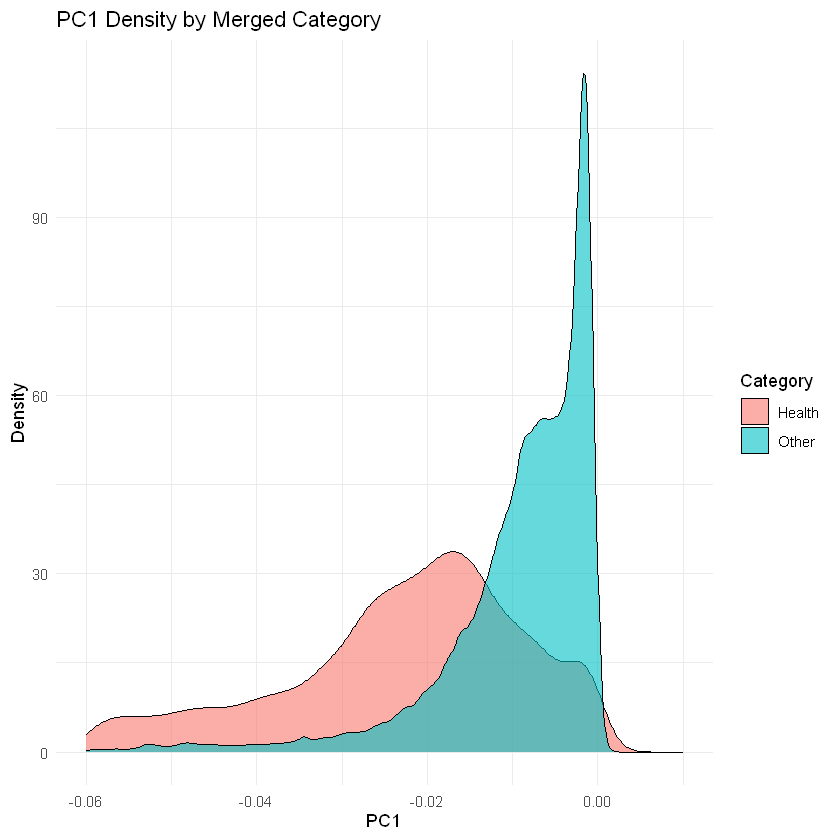

In [32]:
# 示例代码：将原始类别合并为新的类别
pca_scores <- pca_scores %>%
  mutate(
    merged_category = case_when(
      category %in% c("Health") ~ "Health",
      TRUE ~ "Other"
    )
  )

# 绘制 PC1 的密度分布图
ggplot(pca_scores, aes(x = PC1, fill = merged_category)) +
  geom_density(alpha = 0.6) +
  labs(
    title = "PC1 Density by Merged Category",
    x = "PC1",
    y = "Density",
    fill = "Category"
  ) +
  xlim(-0.06, 0.01) +  # 根据数据调整范围
  theme_minimal()

In [35]:
# 计算 PC2 均值和标准差
pca_stats <- pca_scores %>%
  group_by(category) %>%
  summarize(
    mean_pc = mean(PC2, na.rm = TRUE),
    sd_pc = sd(PC2, na.rm = TRUE),
    min_pc = min(PC2, na.rm = TRUE),
    max_pc = max(PC2, na.rm = TRUE)
  ) %>%
  arrange(desc(mean_pc))  # 按均值排序

print(pca_stats)

# A tibble: 20 × 5
   category                 mean_pc   sd_pc min_pc  max_pc
   <chr>                      <dbl>   <dbl>  <dbl>   <dbl>
 1 Health                   0.00222 0.0227  -0.367 0.0582 
 2 Society & Culture       -0.00481 0.0102  -0.211 0.0114 
 3 News                    -0.00481 0.00881 -0.324 0.0349 
 4 Sports                  -0.00553 0.00703 -0.178 0.00917
 5 Culture                 -0.00591 0.0130  -0.266 0.0152 
 6 True Crime              -0.00637 0.0119  -0.368 0.0114 
 7 Technology              -0.00649 0.0119  -0.230 0.0197 
 8 Arts                    -0.00649 0.0130  -0.343 0.0201 
 9 Comedy                  -0.00665 0.0145  -0.513 0.0470 
10 Science                 -0.00695 0.0171  -0.733 0.0199 
11 Business                -0.00706 0.0125  -0.195 0.00974
12 Education               -0.00791 0.0148  -0.323 0.0279 
13 History                 -0.00816 0.0153  -0.409 0.0181 
14 TV & Film               -0.00890 0.0153  -0.427 0.00896
15 Music                   -0.00901 0

Warning message:
"Removed 27429 rows containing non-finite outside the scale range (`stat_density()`)."


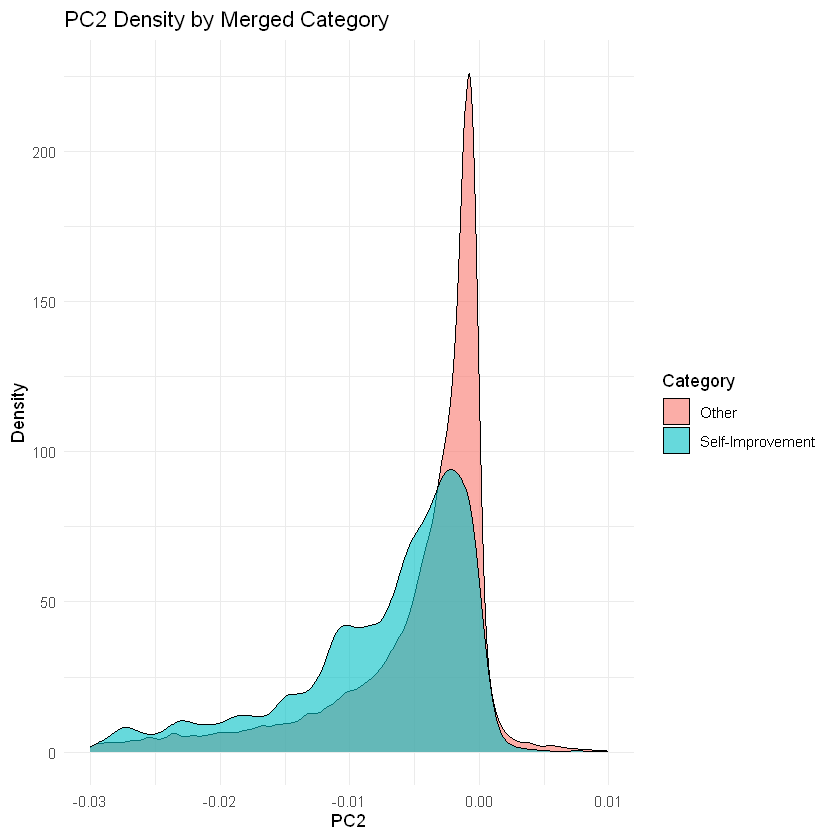

In [38]:
# 示例代码：将原始类别合并为新的类别
pca_scores <- pca_scores %>%
  mutate(
    merged_category = case_when(
      category %in% c("Self-Improvement") ~ "Self-Improvement",
      TRUE ~ "Other"
    )
  )

# 绘制 PC1 的密度分布图
ggplot(pca_scores, aes(x = PC2, fill = merged_category)) +
  geom_density(alpha = 0.6) +
  labs(
    title = "PC2 Density by Merged Category",
    x = "PC2",
    y = "Density",
    fill = "Category"
  ) +
  xlim(-0.03, 0.01) +  # 根据数据调整范围
  theme_minimal()

Warning message:
"Removed 49108 rows containing non-finite outside the scale range (`stat_density()`)."


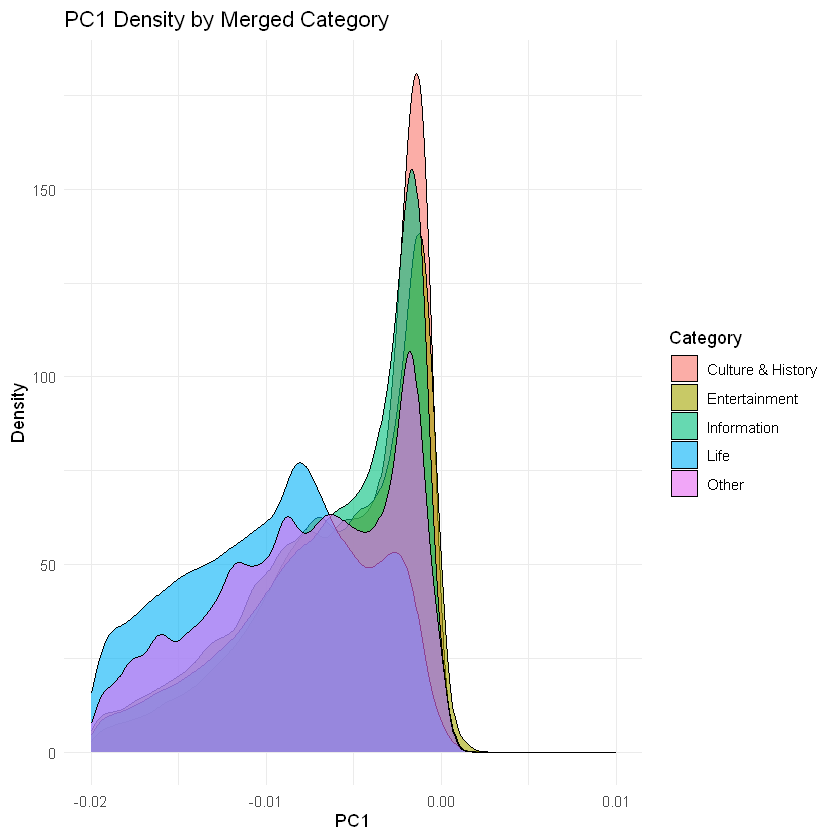

In [6]:
# 示例代码：将原始类别合并为新的类别
pca_scores <- pca_scores %>%
  mutate(
    merged_category = case_when(
      category %in% c("Culture", "Society & Culture","History") ~ "Culture & History",
      category %in% c("TV & Film", "Music", "Comedy","Arts") ~ "Entertainment",
      category %in% c("News", "Technology", "Business") ~ "Information",
      category %in% c("Lifestyle", "Parenting", "Health") ~ "Life",
      TRUE ~ "Other"
    )
  )

# 绘制 PC1 的密度分布图
ggplot(pca_scores, aes(x = PC1, fill = merged_category)) +
  geom_density(alpha = 0.6) +
  labs(
    title = "PC1 Density by Merged Category",
    x = "PC1",
    y = "Density",
    fill = "Category"
  ) +
  xlim(-0.02, 0.01) +  # 根据数据调整范围
  theme_minimal()

Warning message:
"Removed 43132 rows containing non-finite outside the scale range (`stat_density()`)."


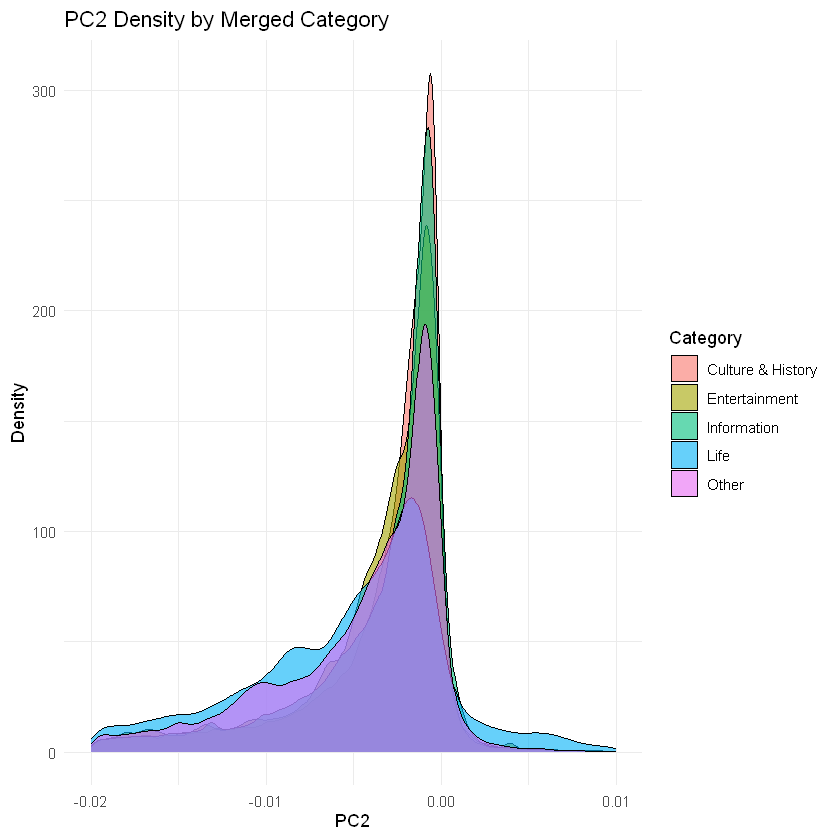

In [7]:
# 绘制 PC1 的密度分布图
ggplot(pca_scores, aes(x = PC2, fill = merged_category)) +
  geom_density(alpha = 0.6) +
  labs(
    title = "PC2 Density by Merged Category",
    x = "PC2",
    y = "Density",
    fill = "Category"
  ) +
  xlim(-0.02, 0.01) +  # 根据数据调整范围
  theme_minimal()

        show_name
           <char>
1: 7 Good Minutes
2: 7 Good Minutes
3: 7 Good Minutes
4: 7 Good Minutes
5: 7 Good Minutes
6: 7 Good Minutes
                                                                         name
                                                                       <char>
1:          Escaping the Negative Cycle: How to Build Unshakeable Self Esteem
2:            Reaching Your Full Potential: Empowering Techniques for Success
3:               Unlocking the Power of Leadership Development | Myles Munroe
4:       Break Free from Mediocrity: Unveiling the Secrets of Self-Motivation
5: Boost Your Mental Agility: How to Think Faster and Nail Every Conversation
6:                  7 Good Minutes: Extra - A simple act of caring creates...
           category
             <char>
1: Self-Improvement
2: Self-Improvement
3: Self-Improvement
4: Self-Improvement
5: Self-Improvement
6: Self-Improvement


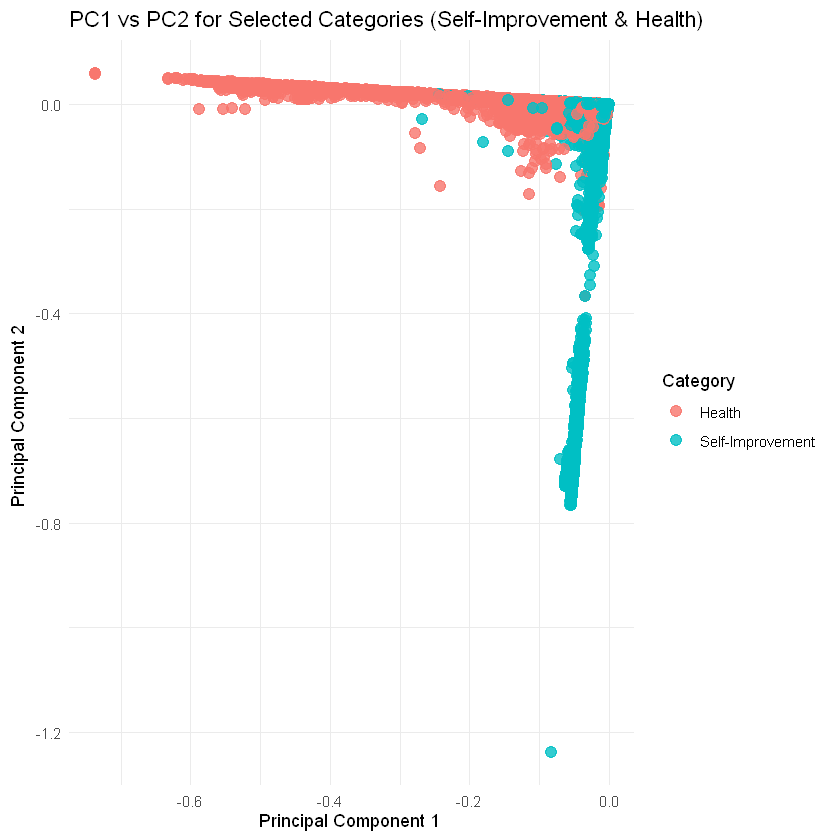

In [40]:
library(dplyr)
library(ggplot2)

# 筛选出 Self-Improvement 和 Health 的数据
selected_data <- pca_scores %>%
  filter(category %in% c("Self-Improvement", "Health"))

# 查看这些类别的 name 和对应的 episode 列表
selected_names_and_episodes <- selected_data %>%
  select(show_name, name, category)

# 打印结果（如果数据量大，可以使用 head 查看前几行）
print(head(selected_names_and_episodes))

# 绘制 PC1 和 PC2 的散点图
ggplot(selected_data, aes(x = PC1, y = PC2, color = category)) +
  geom_point(size = 3, alpha = 0.8) +
  labs(
    title = "PC1 vs PC2 for Selected Categories (Self-Improvement & Health)",
    x = "Principal Component 1 ",
    y = "Principal Component 2 ",
    color = "Category"
  ) +
  theme_minimal() +
  theme(legend.position = "right")

In [ ]:
compare_podcasts <- pca_scores %>%
  filter(show_name %in% c("Lex Fridman Podcast", "Call Her Daddy"))

# 绘制对比图
ggplot(compare_podcasts, aes(x = PC1, y = PC2, color = show_name)) +
  geom_point(size = 5, alpha = 0.8) +
  geom_text(aes(label = show_name), vjust = -1, size = 4) +
  labs(
    title = "Comparison of Two Most Different Podcasts",
    x = "Principal Component 1",
    y = "Principal Component 2",
    color = "Podcast"
  ) +
  theme_minimal() +
  theme(legend.position = "right")

In [8]:
# 计算 PC4 均值和标准差
pca_stats <- pca_scores %>%
  group_by(merged_category) %>%
  summarize(
    mean_pc = mean(PC1, na.rm = TRUE),
    sd_pc = sd(PC1, na.rm = TRUE),
    min_pc = min(PC1, na.rm = TRUE),
    max_pc = max(PC1, na.rm = TRUE)
  ) %>%
  arrange(desc(mean_pc))  # 按均值排序

print(pca_stats)

# A tibble: 5 × 5
  merged_category    mean_pc  sd_pc min_pc   max_pc
  <chr>                <dbl>  <dbl>  <dbl>    <dbl>
1 Culture & History -0.00784 0.0116 -0.255 0.00114 
2 Information       -0.00875 0.0123 -0.454 0.00114 
3 Entertainment     -0.00931 0.0173 -0.604 0.00114 
4 Other             -0.0118  0.0141 -0.385 0.00114 
5 Life              -0.0714  0.139  -0.737 0.000110


In [9]:
# 计算 PC4 均值和标准差
pca_stats <- pca_scores %>%
  group_by(merged_category) %>%
  summarize(
    mean_pc = mean(PC2, na.rm = TRUE),
    sd_pc = sd(PC2, na.rm = TRUE),
    min_pc = min(PC2, na.rm = TRUE),
    max_pc = max(PC2, na.rm = TRUE)
  ) %>%
  arrange(desc(mean_pc))  # 按均值排序

print(pca_stats)

# A tibble: 5 × 5
  merged_category    mean_pc  sd_pc min_pc max_pc
  <chr>                <dbl>  <dbl>  <dbl>  <dbl>
1 Life              -0.00566 0.0201 -0.367 0.0582
2 Information       -0.00600 0.0110 -0.324 0.0349
3 Culture & History -0.00635 0.0133 -0.409 0.0181
4 Entertainment     -0.00713 0.0146 -0.513 0.0470
5 Other             -0.0229  0.0900 -1.24  0.0279


Warning message:
"Removed 49108 rows containing non-finite outside the scale range (`stat_density()`)."


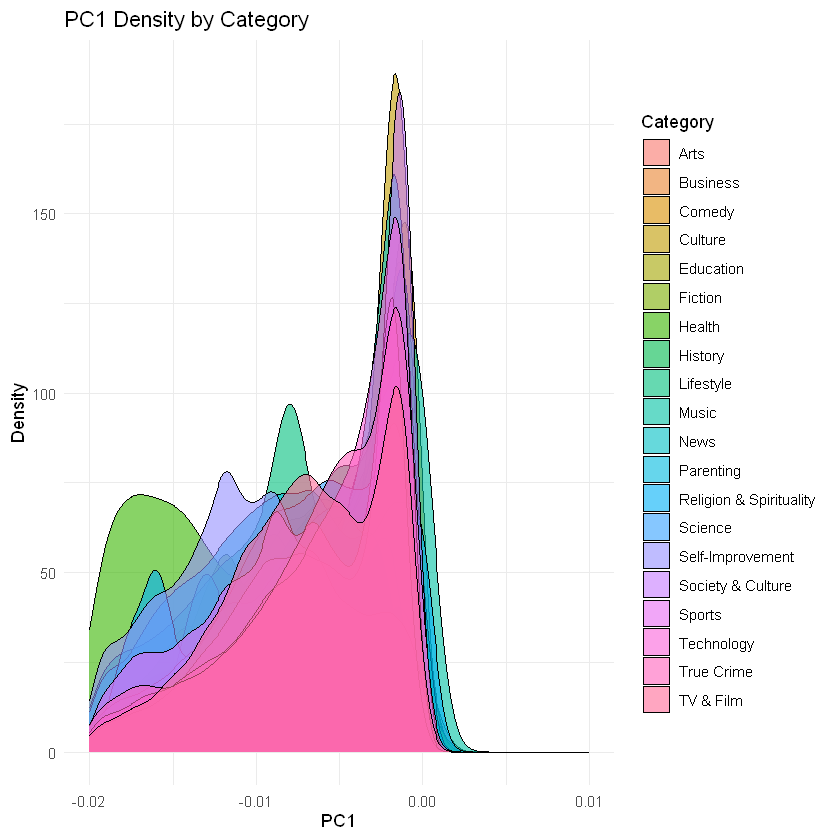

In [31]:
ggplot(pca_scores, aes(x = PC1, fill = category)) +
  geom_density(alpha = 0.6) +
  labs(
    title = "PC1 Density by Category",
    x = "PC1",
    y = "Density",
    fill = "Category"
  ) +
  xlim(-0.02, 0.01) +  # 根据数据调整范围
  theme_minimal()

Warning message:
"Removed 43132 rows containing non-finite outside the scale range (`stat_density()`)."


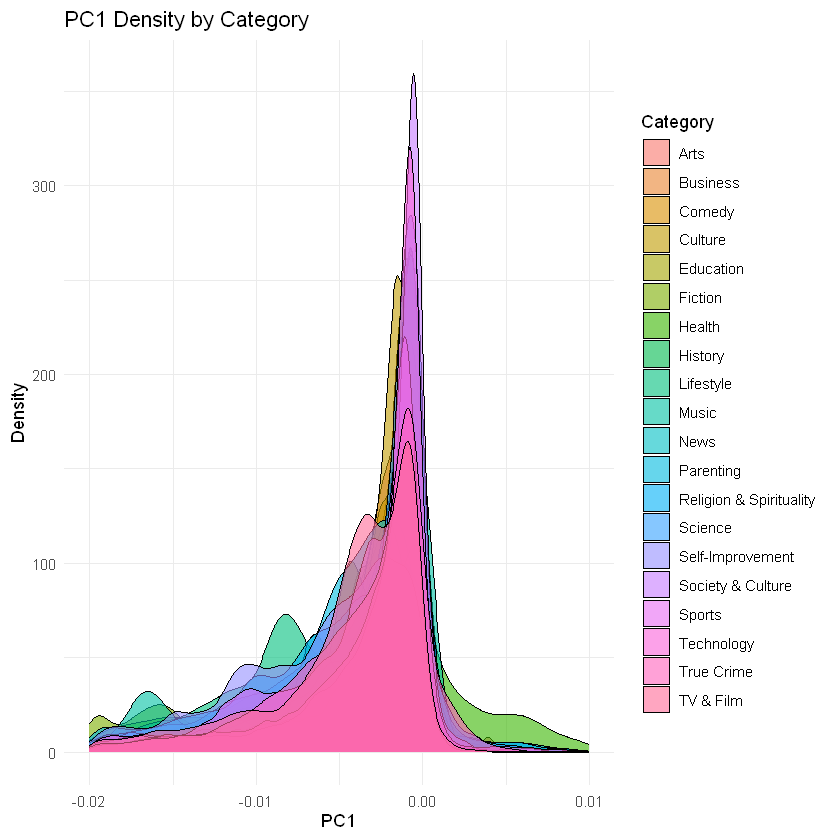

In [33]:
ggplot(pca_scores, aes(x = PC2, fill = category)) +
  geom_density(alpha = 0.6) +
  labs(
    title = "PC1 Density by Category",
    x = "PC1",
    y = "Density",
    fill = "Category"
  ) +
  xlim(-0.02, 0.01) +  # 根据数据调整范围
  theme_minimal()

In [ ]:
ggplot(pca_scores, aes(x = PC4, fill = category)) +
  geom_density(alpha = 0.6) +
  labs(
    title = "PC4 Density by Category (Limited Range)",
    x = "PC4",
    y = "Density",
    fill = "Category"
  ) +
  xlim(-1000, 1000) +  # 根据数据调整范围
  theme_minimal()